# RTBT emittance measurement data analysis 
> 05.31.2021

## Method summary

The goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:
<br>
<br>
$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

We are taking $s_0$ to be the start of the RTBT. To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from wire-scanner $i$ will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then directly related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{lm}$ are the elements of the transfer matrix. Taking 3 measurements with different optics settings between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $b$ from the measured moments and a $3N \times 10$ coefficient array $A$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, so if all these are used the coefficient array will be $15N \times 10$. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized. 

In [1]:
import sys

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import proplot as plot
from pprint import pprint

sys.path.append('/Users/46h/Research/code/')
from accphys.tools import utils
from accphys.tools import beam_analysis as ba 

sys.path.append('/Users/46h/Research/code/accphys/pyorbit/measurement/')
from data_analysis import reconstruct

In [2]:
plot.rc['grid.alpha'] = 0.04
plot.rc['figure.facecolor'] = 'white'

## View Twiss parameters at each scan index 

In [3]:
scan_indices = [0, 1, 3, 7, 11]
twiss_list = [np.loadtxt('./twiss_{}.dat'.format(i)) 
              for i in scan_indices + ['default']]

### Phase advance 

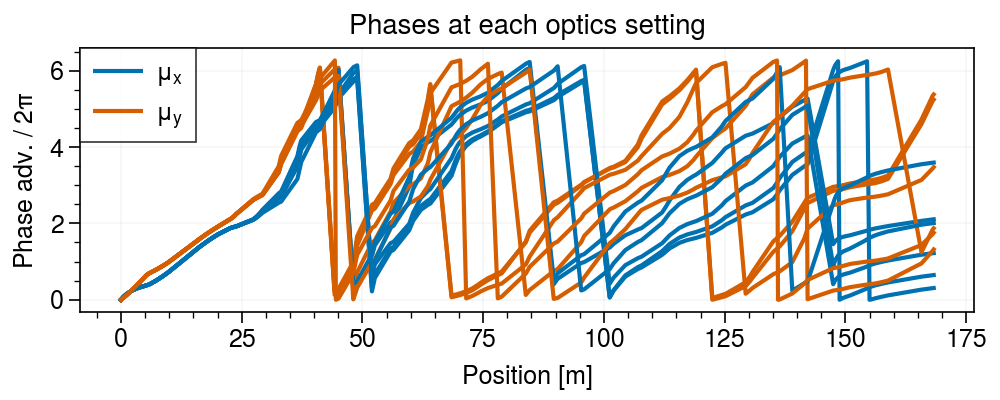

In [4]:
fig, ax = plot.subplots(figsize=(5, 2))
for twiss in twiss_list:
    pos, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.format(cycle='colorblind')
    ax.plot(pos, mu_x)
    ax.plot(pos, mu_y)
ax.legend(labels=[r'$\mu_x$', r'$\mu_y$'], ncols=1);
ax.format(ylabel=r'Phase adv. / 2$\pi$', xlabel='Position [m]',
          title='Phases at each optics setting')

### Beta functions 

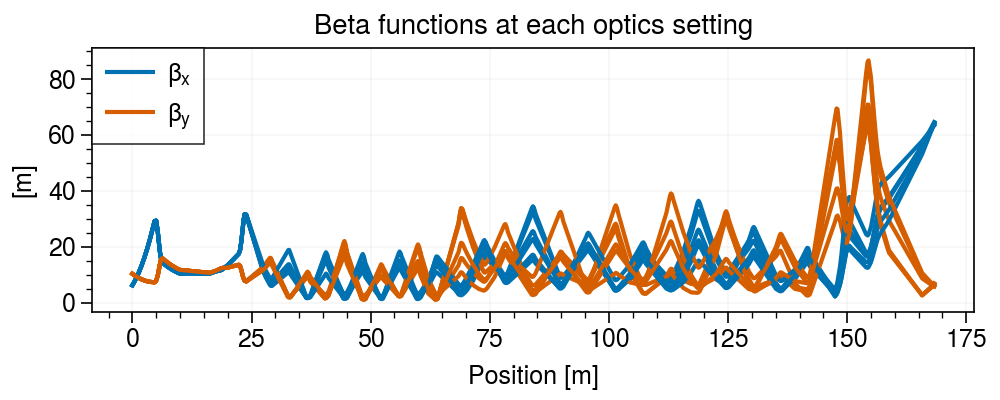

In [5]:
fig, ax = plot.subplots(figsize=(5, 2))
for twiss in twiss_list:
    pos, mu_x, mu_y, alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = twiss.T
    ax.format(cycle='colorblind')
    ax.plot(pos, beta_x)
    ax.plot(pos, beta_y)
ax.legend(labels=[r'$\beta_x$', r'$\beta_y$'], ncols=1);
ax.format(ylabel='[m]', xlabel='Position [m]', 
          title='Beta functions at each optics setting')

## Process wire-scanner data 

### Collect files 

We used a 180 degree range for the phase advances, with 12 steps total. We didn't have time to take measurements at each step. Scans are labeled from 0 through 11 to indicate the position within this array.

In [6]:
filenames_and_indices = []
for filename in utils.list_files('./', join=False):
    if not filename.startswith('Wire') or 'default' in filename:
        continue
    index = int(filename.split('.pta')[0].split('_')[-1])
    filenames_and_indices.append([filename, index])
filenames_and_indices = sorted(filenames_and_indices, key=lambda item: item[1])
filenames, _ = zip(*filenames_and_indices)

We also took a measurement when the machine was at its default setting, but didn't save the transfer matrix. Add this measurement data for now.

In [7]:
filenames = list(filenames)
filenames.append('WireAnalysisFmt-2021.05.31_21.08.18_default.pta.txt')

In [8]:
pprint(filenames)

['WireAnalysisFmt-2021.05.31_21.34.38_0.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.23.35_1.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.40.23_3.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.46.32_7.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.52.00_11.pta.txt',
 'WireAnalysisFmt-2021.05.31_21.08.18_default.pta.txt']


### Extract profile data

The measurement contains a series of positions $\{x_{i}\}$ and amplitudes $\{f(x_i)\}$ with $i$ = 1, ..., $N$. 

In [9]:
def line_to_float_list(line):
    return [float(string) for string in line.split()] 

def lines_to_float_array(lines):
    return np.array([line_to_float_list(line) for line in lines])

In [31]:
class Profile:
    def __init__(self, filename):
        self.filename = filename
        self.data = None
        self.params = None
        self.ws_ids = None
        self.read()
        
    def read(self):
        # Collect the lines corresponding to each wire-scanner
        file = open(self.filename, 'r')
        lines, ws_id = dict(), None
        for line in file:
            line = line.rstrip()
            if line.startswith('RTBT_Diag'):
                ws_id = line.split(':')[-1]
                continue
            if ws_id:
                lines.setdefault(ws_id, []).append(line)
        file.close()
        self.ws_ids = sorted(list(lines))
        
        # Read the lines
        self.data, self.params = dict(), dict()
        for ws_id in self.ws_ids:            
            # Split lines into three sections: params (rms sizes, fit sizes, etc.), 
            # raw (positions and signal amplitudes for each wire), and fit 
            # (Gaussian fit at each position). These sections are separated by 
            # blank lines.
            lines_params, lines_raw, lines_fit = utils.split_list(lines[ws_id], '')[:3]
            
            # Remove headers and dashed lines beneath headers.
            lines_params = lines_params[2:]
            lines_raw = lines_raw[2:]
            lines_fit = lines_fit[2:]     

            # Now the data can be read from the lines. The columns of the 
            # following array are ['pos', 'xraw', 'yraw', 'uraw', 'xpos', 
            # 'ypos', 'upos']. The 'pos' and 'upos' parameters are the same, and 
            # they represent the position along the diagonal scan direction. The 
            # 'xpos' and 'ypos' are then the positions along the horizontal and
            # vertical directions, respectively. Finally, 'xraw', 'yraw', and 
            # 'uraw' are the raw signal amplitude at each position.
            data_arr_raw = lines_to_float_array(lines_raw)
            
            # The same can be said of this array, but instead of 'xraw', 'yraw',
            # and 'uraw', it contains 'xfit', 'yfit', 'ufit', which are the 
            # amplitudes obtained from a Gaussian fit to the signal amplitudes.
            data_arr_fit = lines_to_float_array(lines_fit)
            
            # Merge the two arrays into a single dataframe.
            data_arr = np.hstack([data_arr_raw, data_arr_fit[:, 1:4]])
            columns = ['pos',
                       'xraw','yraw','uraw',
                       'xpos','ypos','upos',
                       'xfit','yfit','ufit']
            self.data[ws_id] = pd.DataFrame(data_arr, columns=columns)
            
            # Create DataFrame containing measurement parameters
            data_arr_params, param_names = [], []
            for line in lines_params:
                strings = line.split()
                param_names.append(strings[0])
                data_arr_params.append([float(string) for string in strings[1:]])
            data_arr_params = np.array(data_arr_params)
            columns = ['xfit','xrms','yfit','yrms','ufit','urms']
            self.params[ws_id] = pd.DataFrame(data_arr_params, columns=columns)
            self.params[ws_id]['name'] = param_names

In [32]:
profiles = [Profile(filename) for filename in filenames]

In [33]:
profiles[0].data['WS24']

,pos,xraw,yraw,uraw,xpos,ypos,upos,xfit,yfit,ufit
0,25.0,-0.002393,-0.009375,-0.005664,17.67775,17.67775,25.0,-0.005425,-0.016155,-0.010578
1,28.0,-0.001904,-0.009229,-0.005371,19.79908,19.79908,28.0,-0.005417,-0.016044,-0.010578
2,31.0,-0.002246,-0.009961,-0.005859,21.92041,21.92041,31.0,-0.005403,-0.015826,-0.010576
3,34.0,-0.002100,-0.009521,-0.005811,24.04174,24.04174,34.0,-0.005380,-0.015418,-0.010574
4,37.0,-0.002637,-0.009277,-0.005811,26.16307,26.16307,37.0,-0.005340,-0.014677,-0.010569
...,...,...,...,...,...,...,...,...,...,...
85,280.0,-0.001953,-0.008838,-0.006006,197.99080,197.99080,280.0,-0.005434,-0.016259,-0.010579
86,283.0,-0.001807,-0.008301,-0.005273,200.11213,200.11213,283.0,-0.005434,-0.016259,-0.010579
87,286.0,-0.001416,-0.008350,-0.005518,202.23346,202.23346,286.0,-0.005434,-0.016259,-0.010579
88,289.0,-0.001416,-0.008496,-0.005908,204.35479,204.35479,289.0,-0.005434,-0.016259,-0.010579


In [34]:
profiles[0].params['WS24']

,xfit,xrms,yfit,yrms,ufit,urms,name
0,16.756203,14.797298,18.598308,16.346290,16.161669,15.271240,Area
1,0.414684,0.426611,0.452315,0.448193,0.383273,0.387354,Ampl
2,92.189046,92.293212,92.172151,93.344580,103.489345,112.817259,Mean
3,16.120111,13.139550,16.403726,12.641842,16.822406,11.804634,Sigma
4,-0.005434,-0.002148,-0.016268,-0.009302,-0.010788,-0.005518,Offset
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Slope


### View profiles 

In [35]:
def plot_profiles(profiles, ws_ids=None, show_fit=False, kws_raw=None, 
                  kws_fit=None, width=8, vscale=1.4):
    if kws_raw is None:
        kws_raw = dict()
    if kws_fit is None:
        kws_fit = dict()
    kws_raw['legend'] = kws_fit['legend'] = False
    kws_raw.setdefault('marker', '.')
    kws_raw.setdefault('ms', 3)
    kws_raw.setdefault('lw', 0)
    kws_fit.setdefault('color', 'k')
    kws_fit.setdefault('alpha', 0.2)
    kws_fit.setdefault('zorder', 0)
    
    if ws_ids is None:
        ws_ids = profiles[0].ws_ids
    n_meas = len(profiles)
    fig, axes = plot.subplots(nrows=n_meas, ncols=3, spanx=False,
                              figsize=(width, vscale*n_meas))
    
    def _plot(opt='raw', **kws):
        for i, profile in enumerate(profiles):
            for ws_id in ws_ids:
                for ax, var in zip(axes[i, :], ['x', 'y', 'u']):
                    key1, key2 = var + 'pos', var + opt
                    df = profile.data[ws_id]
                    df[[key1, key2]].plot(key1, ax=ax, **kws)
        
    _plot('raw', **kws_raw)
    axes[0, -1].legend(labels=ws_ids, fontsize='small', loc=(1.02, 0), ncols=1)
    if show_fit:
        _plot('fit', **kws_fit)
        
    axes.format(ylabel='Signal', grid=False, 
                toplabels=['Horizontal', 'Vertical', 'Diagonal'],
                leftlabels=scan_indices + ['default'])
    for ax, label in zip(axes[-1, :], ['x', 'y', 'u']):
        ax.format(xlabel=label)
    for ax in axes:
        ax.grid(axis='y')
    return axes

In [36]:
ws_ids = ['WS20', 'WS21', 'WS23', 'WS24']
kws_raw = dict(legend=False, marker='.', ms=3, lw=0)
kws_fit = dict(legend=False, color='k', alpha=0.2, zorder=0)

#### Raw

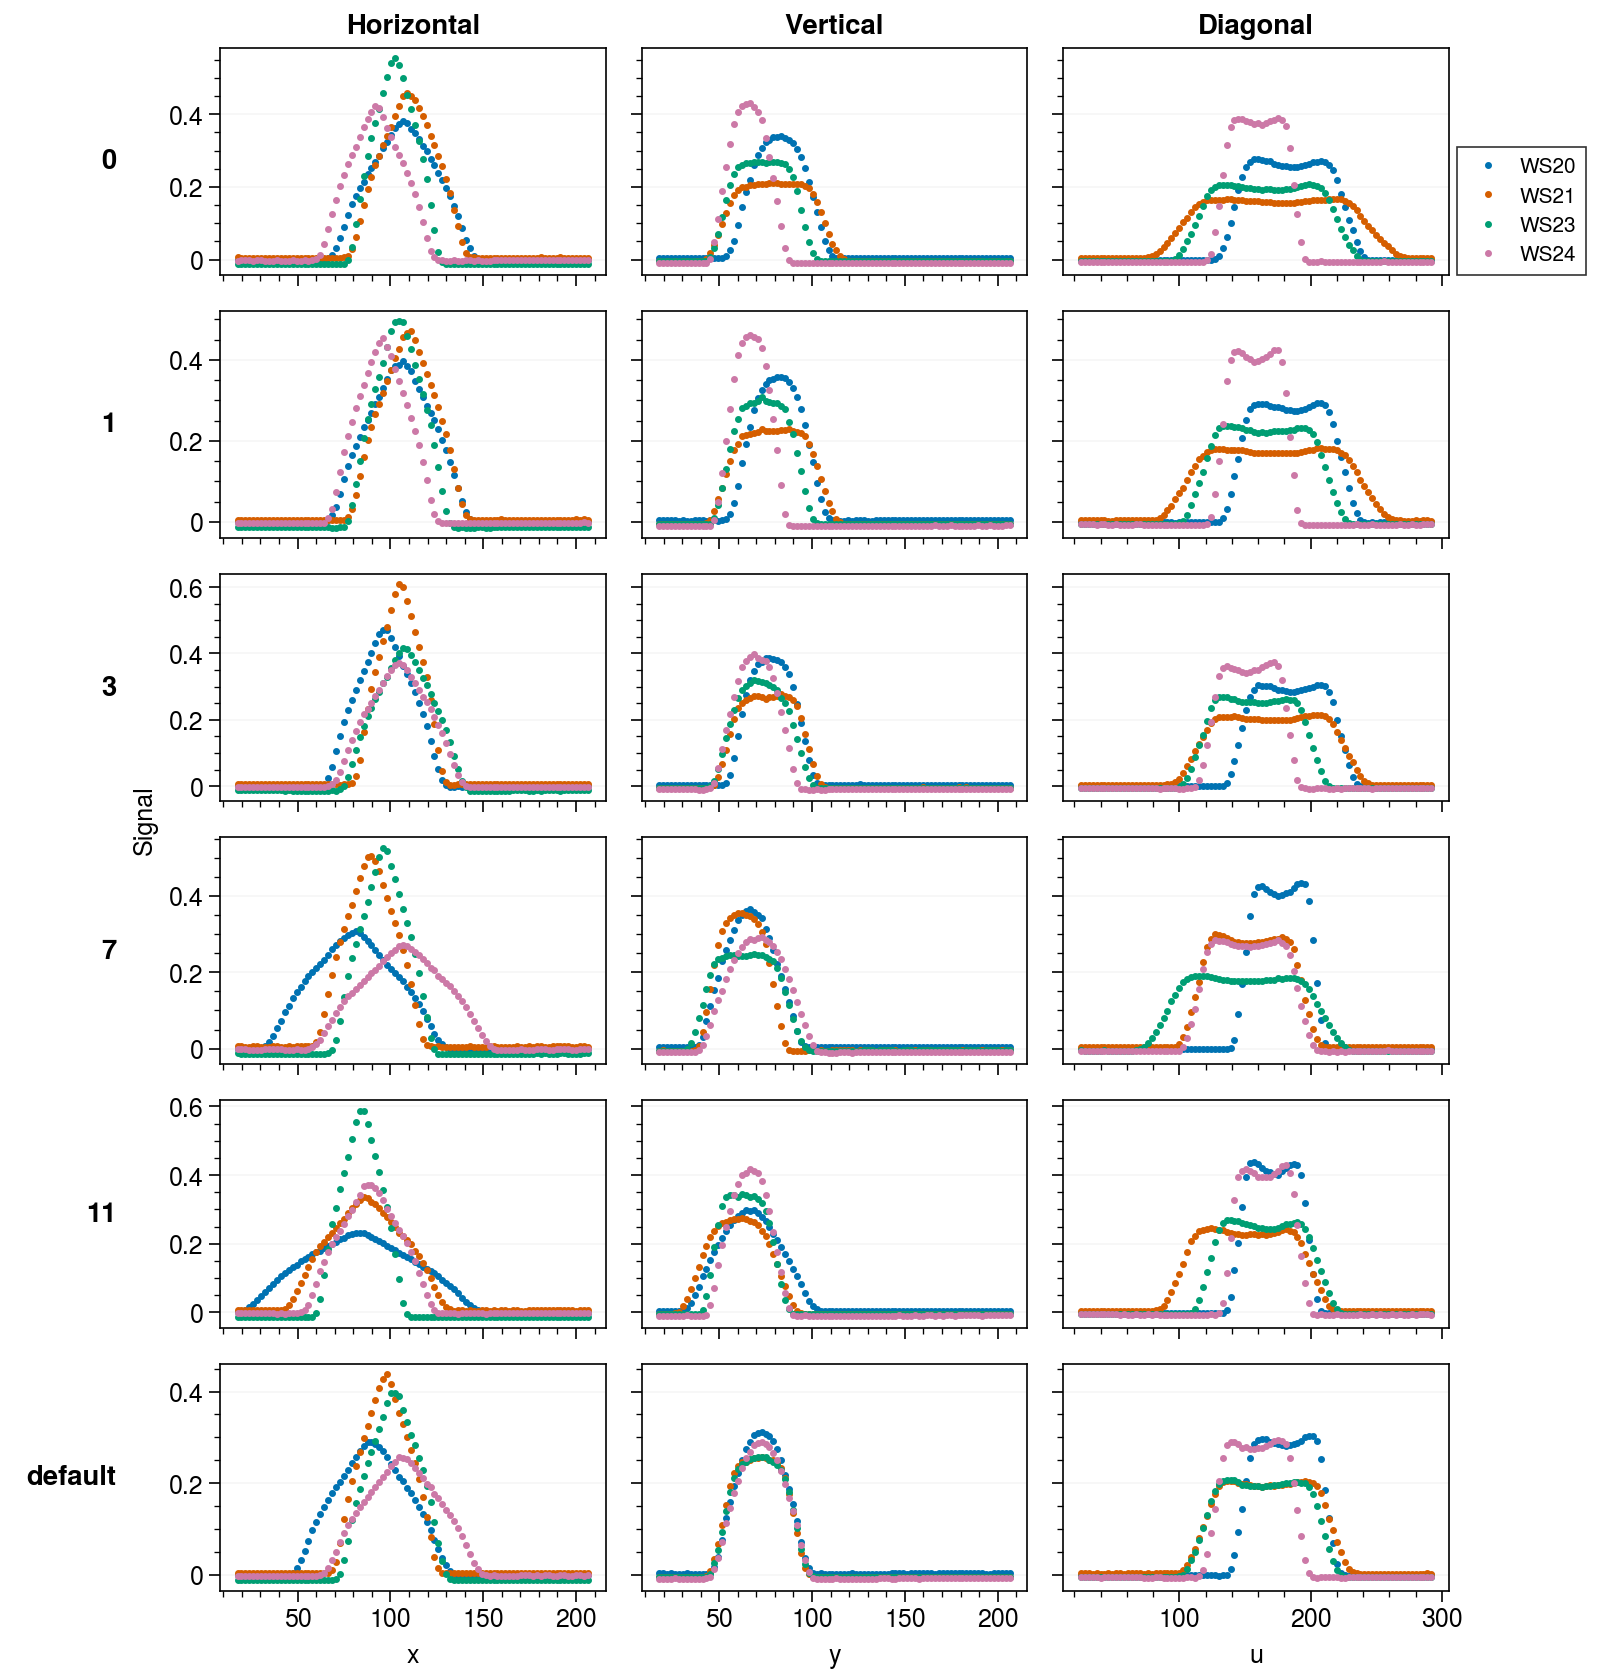

In [37]:
axes = plot_profiles(profiles, ws_ids, show_fit=False, kws_raw=kws_raw, kws_fit=kws_fit)

#### Raw + fit

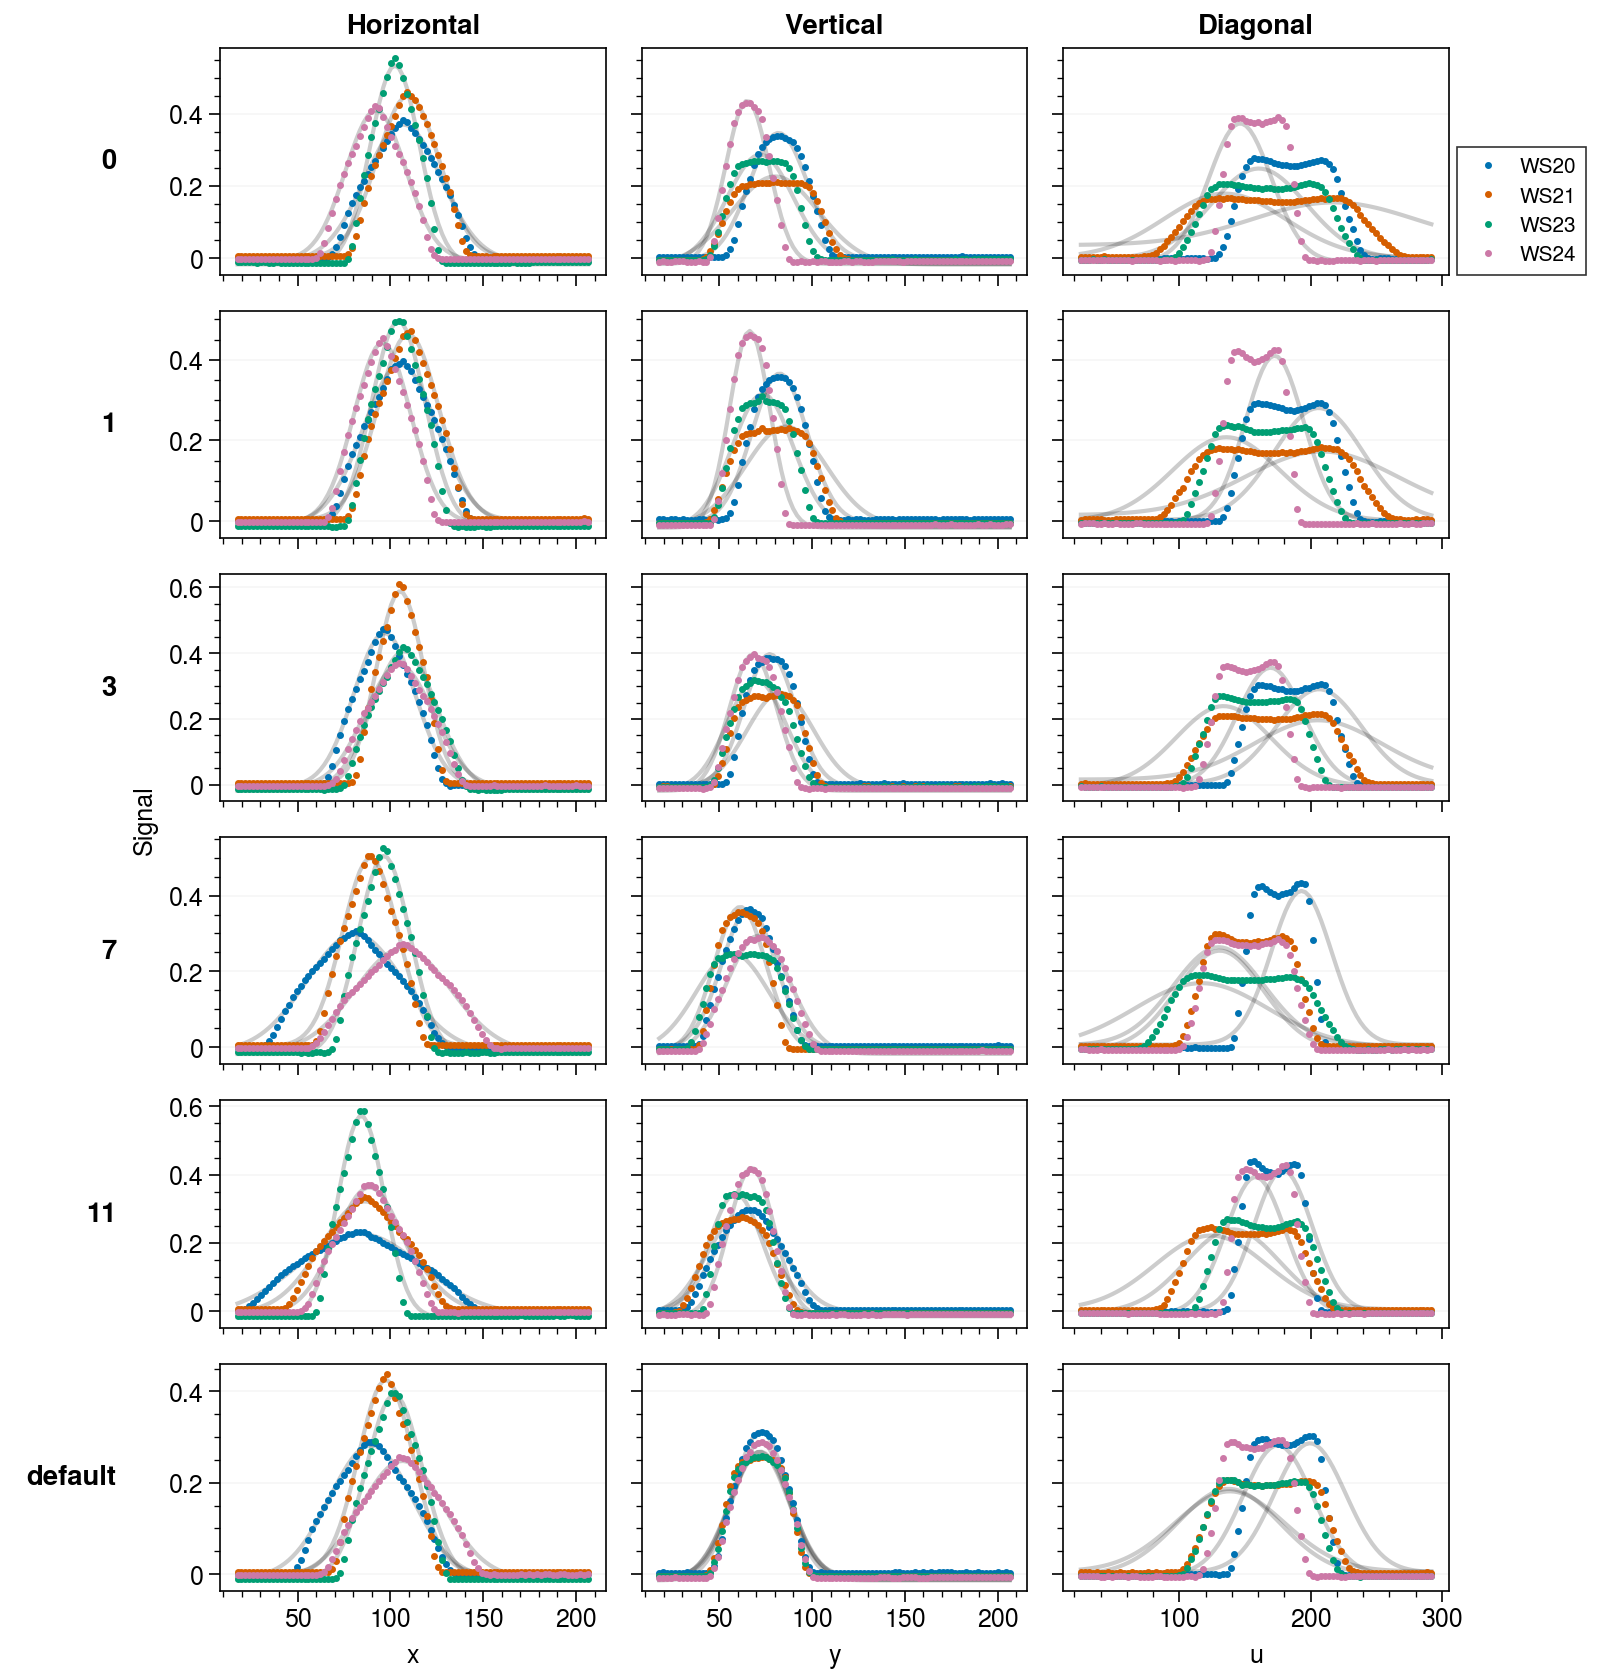

In [38]:
axes = plot_profiles(profiles, ws_ids, show_fit=True, kws_raw=kws_raw, kws_fit=kws_fit)

#### Comments
* Diagonal profile is bi-modal; Gaussian fit doesn't do well.
* The means fo the distributions do seem to move around a bit between measurements. 

### Estimate moments from profiles 

We're going to ignore the production settings since I didn't compute the transfer matrix for this setting. 

In [51]:
profiles = profiles[:-1]

OpenXAL estimates the rms beam size from the profile. I need to find out how it does this; I ran into trouble when I estimated the means because the profiles have asymmetric tails, so the mean didn't align with the location of the peak.

## Reconstruct beam moments

For now, use the rms beam sizes from that were calculated by the PTA app.

In [84]:
def get_sig_xy(sig_xx, sig_yy, sig_uu, diag_wire_angle):
    phi = np.radians(90.0) + diag_wire_angle # angle of u axis above x-axis
    sin, cos = np.sin(phi), np.cos(phi)
    sig_xy = (sig_uu - sig_xx*cos**2 - sig_yy*sin**2) / (2 * sin * cos)
    return sig_xy

In [85]:
diag_wire_angle = np.radians(-45.0) # angle of diagonal wire above x-axis

In [89]:
moments = []
for profile in profiles:
    for ws_id in ws_ids:
        df = profile.params[ws_id]
        sig_xx = float(df.loc[df.name == 'Sigma', 'xrms'])**2
        sig_yy = float(df.loc[df.name == 'Sigma', 'yrms'])**2
        sig_uu = float(df.loc[df.name == 'Sigma', 'urms'])**2
        sig_xy = get_sig_xy(sig_xx, sig_yy, sig_uu, diag_wire_angle)
        moments.append([sig_xx, sig_yy, sig_xy])
moments = np.array(moments)
print('moments.shape =', moments.shape)

moments.shape = (20, 3)


Collect the transfer matrices calculated from the online model in OpenXAL.

In [90]:
transfer_mats = []
for i in scan_indices:
    matrix_elems_at_each_ws = np.loadtxt('./transfer_mat_elems_{}.dat'.format(i))
    # Each row gives the 16 elements at a different wire-scanner in the order
    # (WS02, WS20, WS21, WS23, WS24). We didn't take data from WS02, so skip the
    # first row.
    for matrix_elements in matrix_elems_at_each_ws[1:, :]:
        transfer_mats.append(matrix_elements.reshape((4, 4)))
transfer_mats = np.array(transfer_mats)
print('transfer_mats.shape =', transfer_mats.shape)

transfer_mats.shape = (20, 4, 4)


Perform least-squares fit.

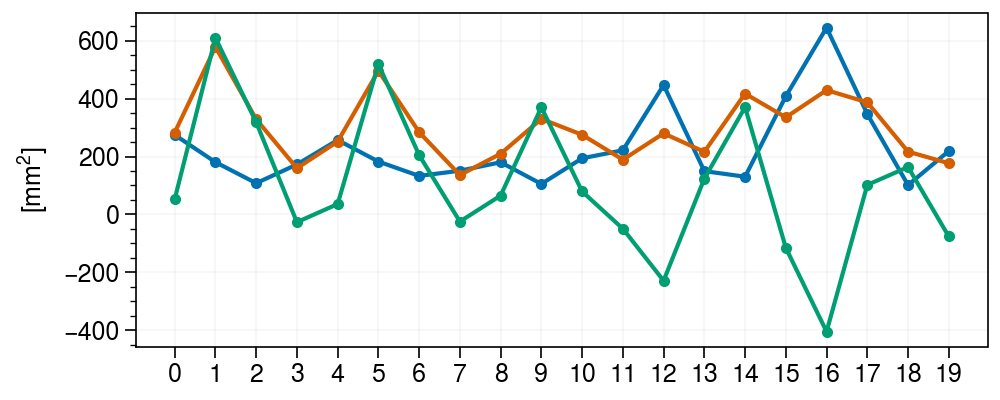

In [91]:
fig, ax = plot.subplots(figsize=(5, 2))
plt_kws = dict(marker='o', ms=3)
ax.plot(moments[:, 0], **plt_kws)
ax.plot(moments[:, 1], **plt_kws)
ax.plot(moments[:, 2], **plt_kws)
ax.format(ylabel=r'[mm$^2$]', xticks=range(len(moments)), xtickminor=False)

In [93]:
Sigma = reconstruct(transfer_mats, moments)
print(Sigma)

[[ 2.95421352e-20  2.00899923e+01  2.69067050e+03 -1.24730058e+02]
 [ 2.00899923e+01  1.70998846e+01  4.95479913e+02  5.43688939e+01]
 [ 2.69067050e+03  4.95479913e+02  7.69411698e+01  1.30274068e+01]
 [-1.24730058e+02  5.43688939e+01  1.30274068e+01  6.43794877e+00]]


Well, that's not good. I'm not sure what's wrong. Why is $\langle{xy}\rangle$ not zero all the time?